# Folded Klein Bottle

An example of an application of the `circle_bundles` pipeline to a dataset where the fibers of the underlying model are topological circles but not geometric ones, and $\text{PCA}_{2}$ fails produce local circular coordinates which are usable for analysis. We instead use the DREiMac library's topologically-flavored circular coordinates algorithm.

The model manifold $M$ is defined as follows: let $\gamma:\mathbb{R}\to \mathbb{R}^{4}$ be defined by $\gamma(t) = (\sin (t), \cos(t), \sin(2t),0)$ for all $t\in\mathbb{R}$, and let $F = \gamma(\mathbb{R})\subset\mathbb{R}^{4}$. Note that $F$ is topologically a circle, but geometrically it looks "folded over" in 3-dimensional space (identified with a subspace of $\mathbb{R}^{4}$ in the obvious way).  In particular, $F$ is invariant under a reflection in the $x$ and $y$ coordinates. Now, define $R:[0,2\pi]\to SO(4)$ by 

$$R(t) = \left(\begin{array}{cccc}
a & b & 0 & d\\
b & a & 0 & -d\\
0 & 0 & 1 & 0\\
-d & d & 0 & c\\
\end{array}\right)$$

where 

$$\tau = \frac{t}{2},\hspace{1cm}a = \frac{1 + \cos(\tau)}{2},\hspace{1cm}b = \frac{1 - \cos(\tau)}{2}$$

$$c = \cos(\tau),\hspace{1cm}d =  \frac{\sqrt{2}}{2}\sin(\tau)$$

Observe in particular that $R(0) = I$, $R(2\pi)$ is the matrix which maps $(x,y,z,w)$ to $(y,x,z,-w)$ and $R(t)$ fixes the $z$-axis for all $t$. Finally, define $\widetilde{M}$ by 

$$\widetilde{M} = \{(u,v)\in\mathbb{R}^{4}\times\mathbb{R}^{4}: u = \gamma (t), \ v\in R(t)F\}$$

and apply an $SO(8)$ rotation to obtain the manifold $M$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

from dreimac import CircularCoords

import circle_bundles as cb

First, generate a noisy sampling of the manifold $M$:

In [2]:
n_landmarks = 10000
sigma = 0.05
rng = np.random.default_rng(0)

data = cb.sample_foldy_klein_bottle(n_landmarks, noise = sigma, rng = rng)[0]

Show a PCA visualization of the dataset:

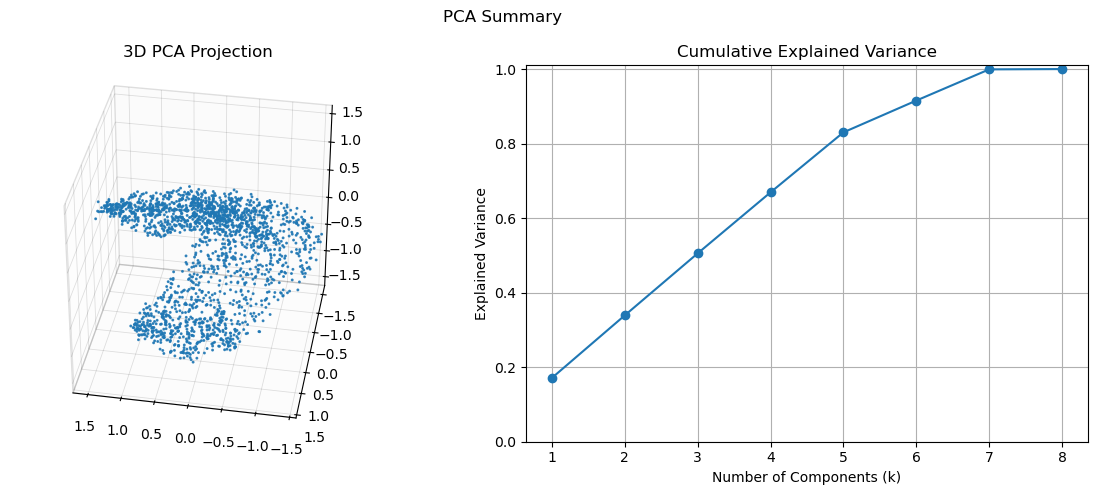

In [3]:
cb.show_pca(data, size = 0.2, elev = 35, azim = 100)

Compute persistence diagrams from a subsample of the data:

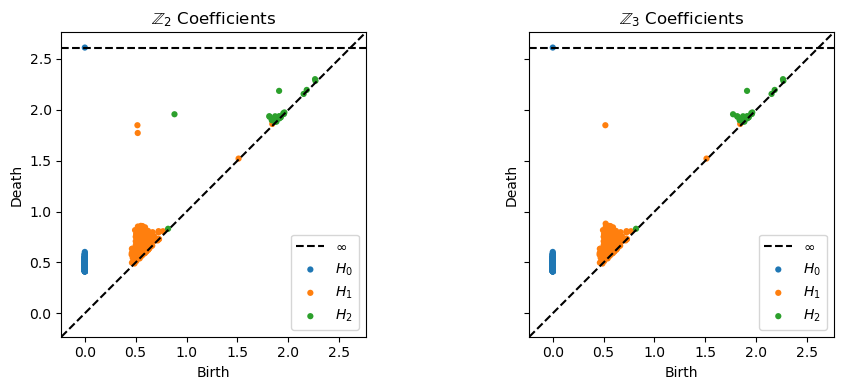

In [4]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title=r"$\mathbb{Z}_{2}$ Coefficients")
plot_diagrams(dgms_3, ax=axes[1], title=r"$\mathbb{Z}_{3}$ Coefficients")


plt.tight_layout()
plt.show()


The persistence diagrams above reflect the Klein bottle topology of the underlying manifold $M$. In particular, note that $H^{1}(M;\mathbb{Z})\cong \mathbb{Z}\oplus\mathbb{Z}_{2}$ and $H^{2}(M;\mathbb{Z}) = 0$. 

To certify this topology with `circle_bundles`, use the DREiMac circular coordinates algorithm to construct a base projection map to $\mathbb{S}^{1}$ which captures the topological feature represented by the 1-dimensional $\mathbb{Z}_{3}$ persistent class:

In [3]:
cc = CircularCoords(data, prime = 3, n_landmarks = 500)
base_angles = cc.get_coordinates()

Construct a cover of the base space $\mathbb{S}^{1} = \mathbb{R} / (2\pi\mathbb{Z})$ by metric balls around equally-spaced landmarks:

In [4]:
n_landmarks = 12
landmarks = np.linspace(0,2*np.pi,n_landmarks,endpoint = False).reshape(-1,1)
overlap = 1.4
radius = overlap * np.pi / n_landmarks

cover = cb.get_metric_ball_cover(
    base_angles.reshape(-1,1),
    landmarks,
    radius = radius,
    metric = cb.S1AngleMetric())

Show PCA projections of the data in several $\pi^{-1}(U_{j})$:

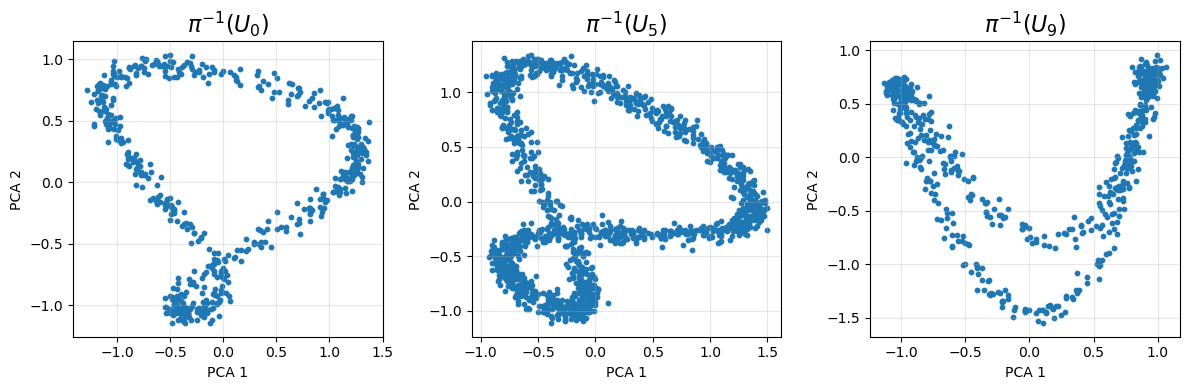

In [7]:
fig, axes = cb.get_local_pca(data, 
                      cover.U,
                      to_view = [0,5,9],
                     )
plt.show()

The PCA projections indicate that the fibers are not geometric circles, and $\text{PCA}_{2}$ will fail to produce reasonable local circular coordinates or reliable transition matrices. 

On the other hand, since the fibers look like $\mathbb{S}^{1}$ $\textit{topologically}$, we expect each set $\pi^{-1}(U_{j})$ to produce a prominant 1-dimensional persistent homology class. Compute the persistence diagrams:

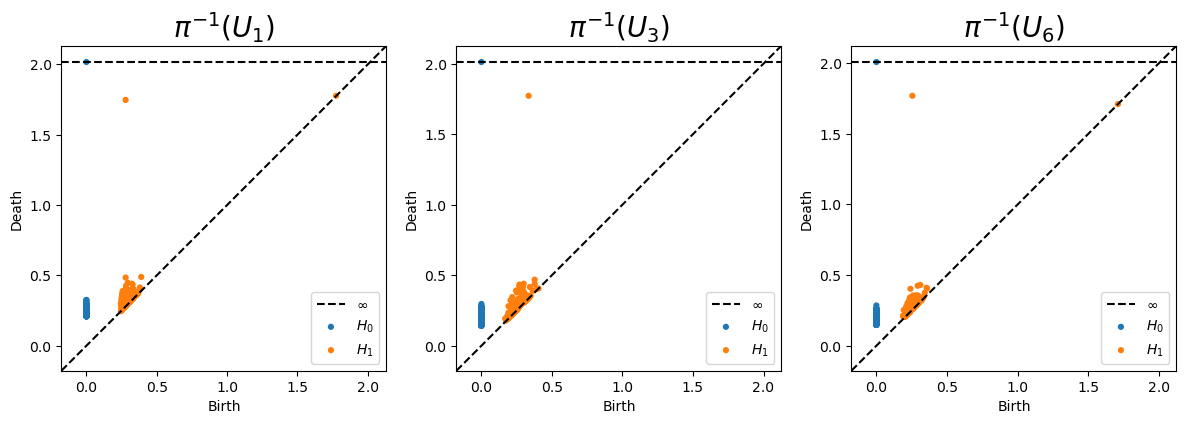

In [8]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [1,3,6], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Use the DREiMac circular coordinates algorithm to construct a system of local circular coordinate functions:

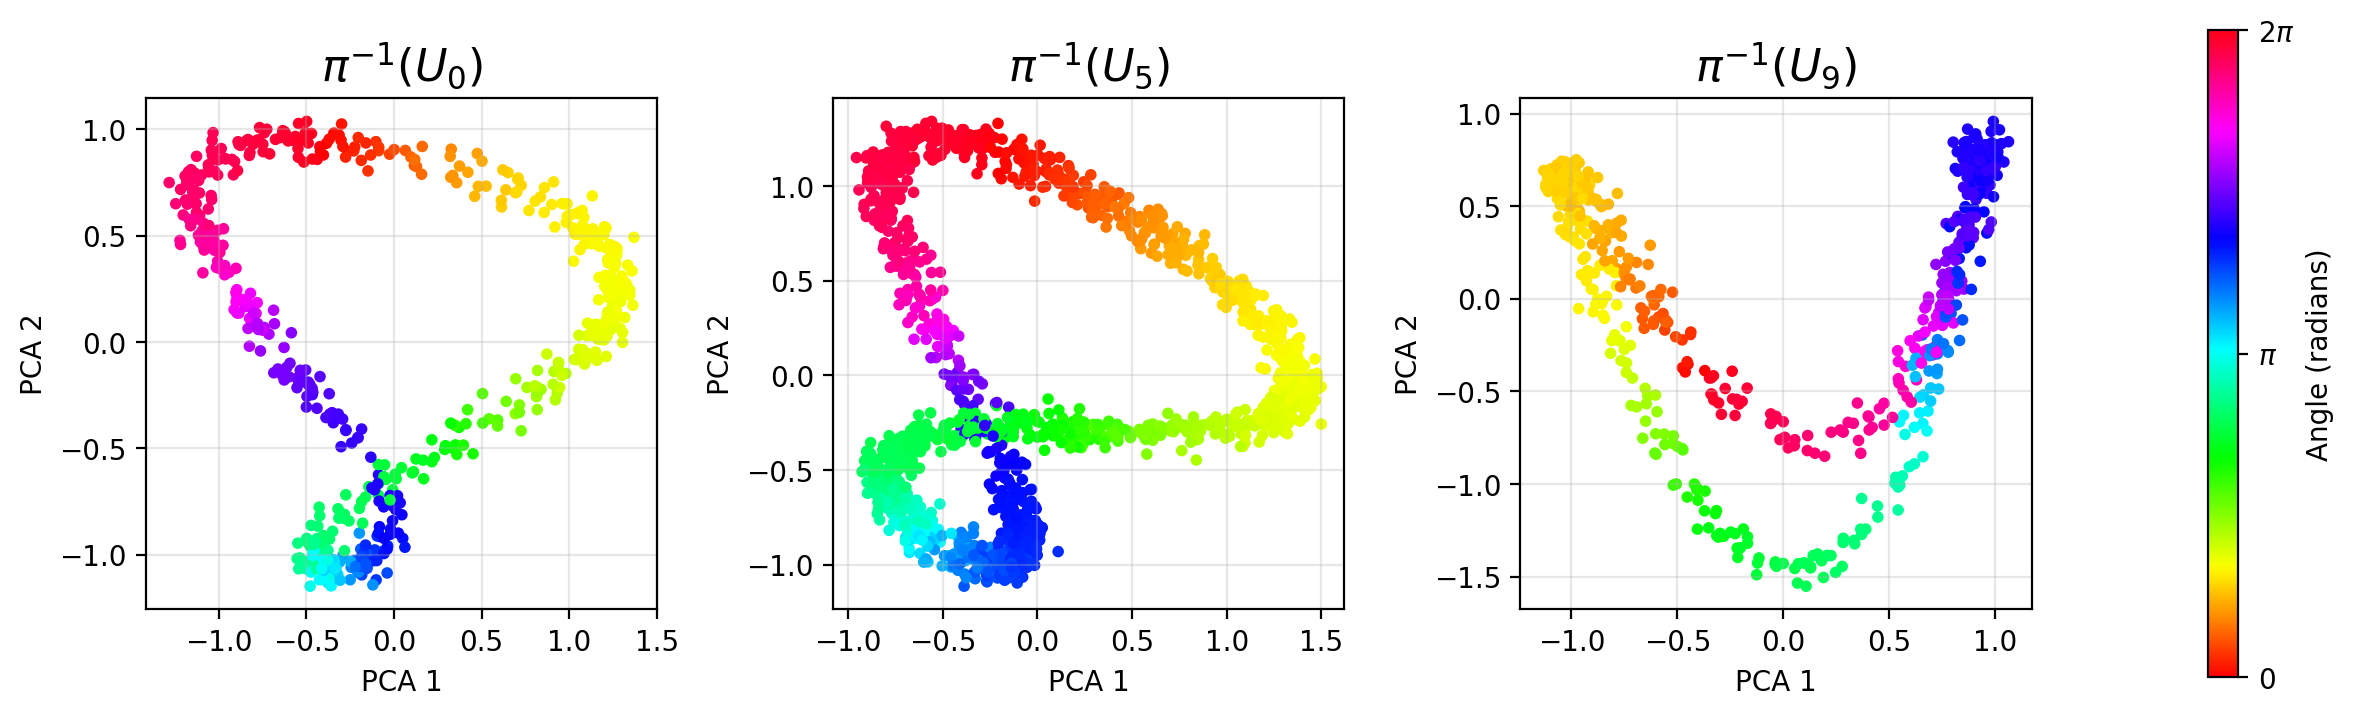

In [7]:
cc_alg = cb.DreimacCCConfig(landmarks_per_patch = 200, CircularCoords_cls = CircularCoords)

bundle = cb.Bundle(X = data, U = cover.U)
triv_result = bundle.get_local_trivs(cc = cc_alg)

# Show local PCA projections colored according to angles computed with Dreimac:
fig, axes = cb.get_local_pca(
    data, 
    cover.U,
    f = triv_result.f,
    to_view = [0,5,9],
    show_colorbar = True,
    )
plt.show()

Now, compute characteristic classes:

In [10]:
class_result = bundle.get_classes(show_classes = True)

<IPython.core.display.Math object>

From the computed characteristic classes, we can infer that the 2-manifold underlying the dataset has the topology of a Klein bottle, as expected. 